<a href="https://colab.research.google.com/github/malleswarrao/yesbank_analysis/blob/main/yesbank_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Yes Bank is a well-known bank in the Indian financial domain. Since 2018, it has been in the news because of the fraud case involving Rana Kapoor. Owing to this fact, it was interesting to see how that impacted the stock prices of the company and whether Time series models or any other predictive models can do justice to such situations. This dataset has monthly
#stock prices of the bank since its inception and includes closing, starting, highest, and lowest
# stock prices of every month. The main objective is to predict the stock’s closing price of the month.



In [ ]:
import numpy as np
import pandas as pd
from numpy import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import *
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Importing the dataset
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AlmaBetter/Capstone Projects/Capstone 2- Regression/Yes Bank Stock Closing Price Prediction/data_YesBank_StockPrices.csv')

In [ ]:
#Data Inspection
df.head()

,Date,Open,High,Low,Close
0,Jul-05,13.00,14.00,11.25,12.46
1,Aug-05,12.58,14.88,12.55,13.42
2,Sep-05,13.48,14.87,12.27,13.30
3,Oct-05,13.20,14.47,12.40,12.99
4,Nov-05,13.35,13.88,12.88,13.41


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185 entries, 0 to 184
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    185 non-null    object 
 1   Open    185 non-null    float64
 2   High    185 non-null    float64
 3   Low     185 non-null    float64
 4   Close   185 non-null    float64
dtypes: float64(4), object(1)
memory usage: 7.4+ KB


In [ ]:
df.describe(include='all')

,Date,Open,High,Low,Close
count,185,185.000000,185.000000,185.000000,185.000000
unique,185,NaN,NaN,NaN,NaN
top,Oct-15,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN
mean,NaN,105.541405,116.104324,94.947838,105.204703
std,NaN,98.879850,106.333497,91.219415,98.583153
min,NaN,10.000000,11.240000,5.550000,9.980000
25%,NaN,33.800000,36.140000,28.510000,33.450000
50%,NaN,62.980000,72.550000,58.000000,62.540000
75%,NaN,153.000000,169.190000,138.350000,153.300000


In [ ]:
# duplicate
len(df[df.duplicated()])

0

In [ ]:
numeric_features = df.columns
numeric_features

Index(['Date', 'Open', 'High', 'Low', 'Close'], dtype='object')

### Exploratory Data Analysis

In [ ]:
# setting dates as the index to the the dataframe
stock_price = df.set_index('Date')

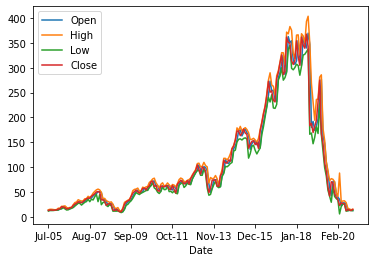

In [ ]:
stock_price.plot.line()

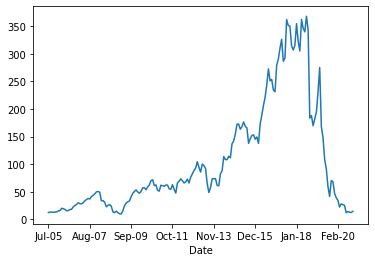

In [ ]:
line= stock_price['Close'].plot.line()

In [ ]:
indep_var=df[['High','Low','Open']]
dep_var=df['Close']

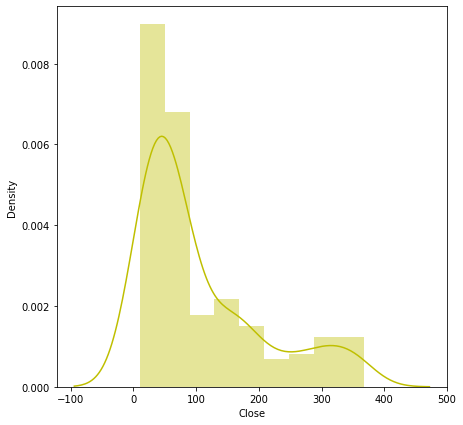

In [ ]:
#Dependent variable 'close'
plt.figure(figsize=(7,7))
sns.distplot(dep_var,color="y")

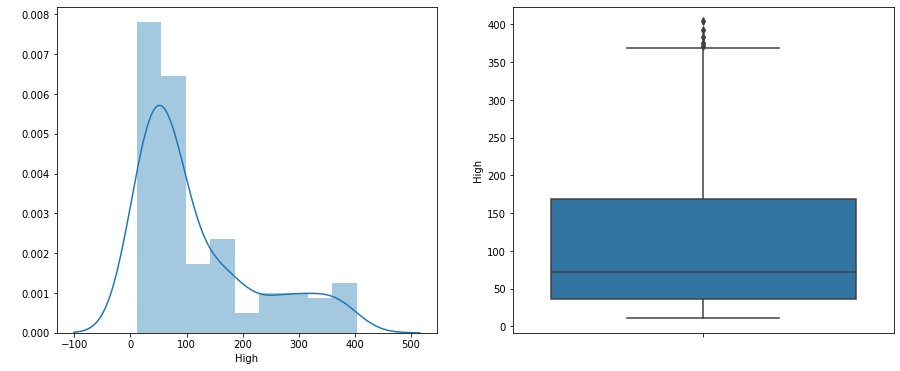

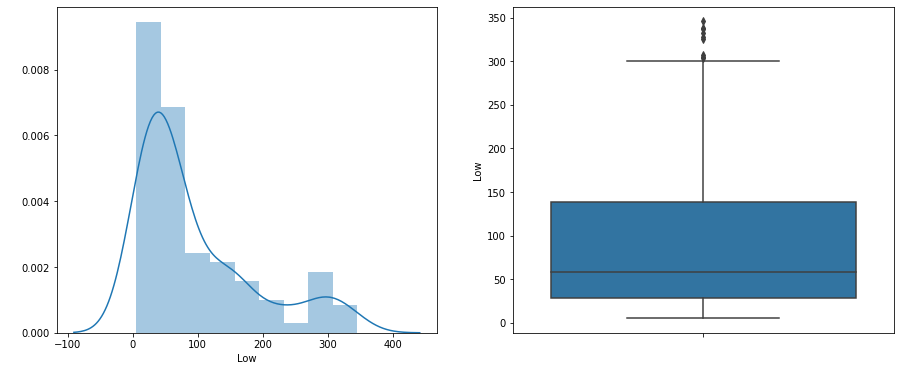

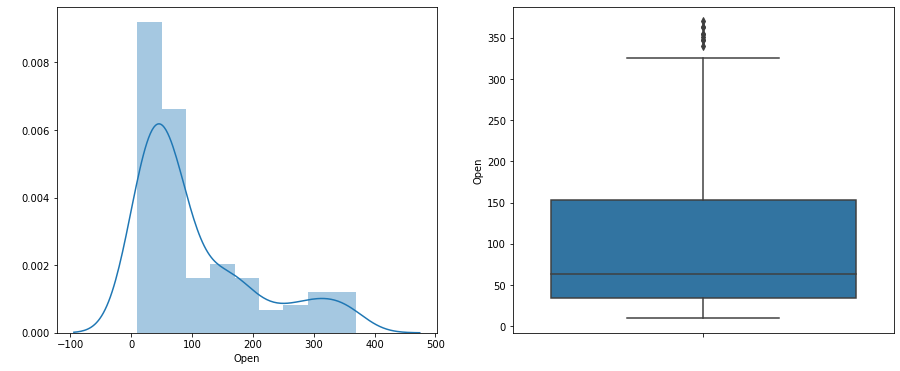

In [ ]:
#plots for independent variables
for var in indep_var:
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    fig = sns.distplot(df[var].dropna())
    fig.set_ylabel(' ')
    fig.set_xlabel(var)

    plt.subplot(1, 2, 2)
    fig = sns.boxplot(y=df[var])
    fig.set_title('')
    fig.set_ylabel(var)

# Data Transformation

Since our data is skewed, we will perform some transformations during regression analysis. Let's visualize how our data will look like post transformation.

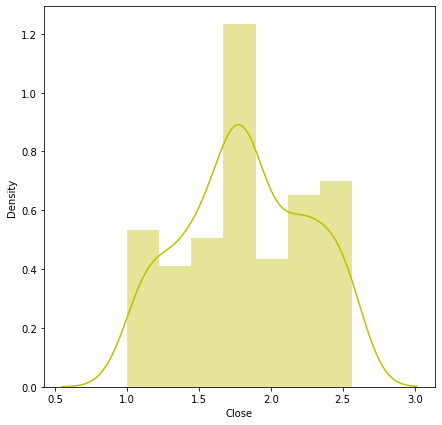

In [ ]:
# Dependent variable 'Close'
plt.figure(figsize=(7,7))
sns.distplot(np.log10(dep_var),color="y")

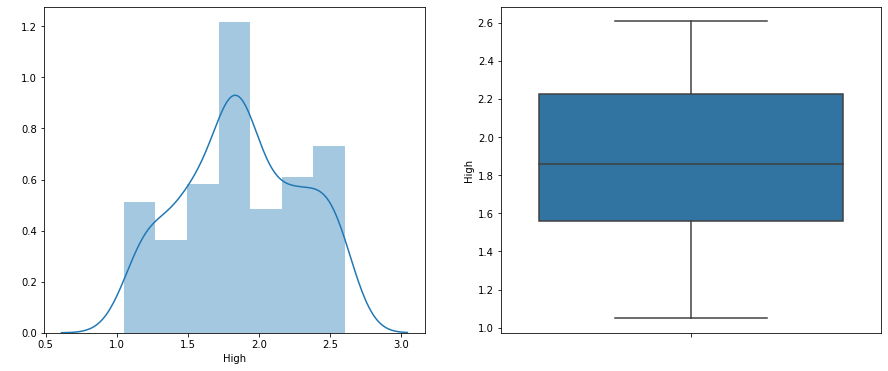

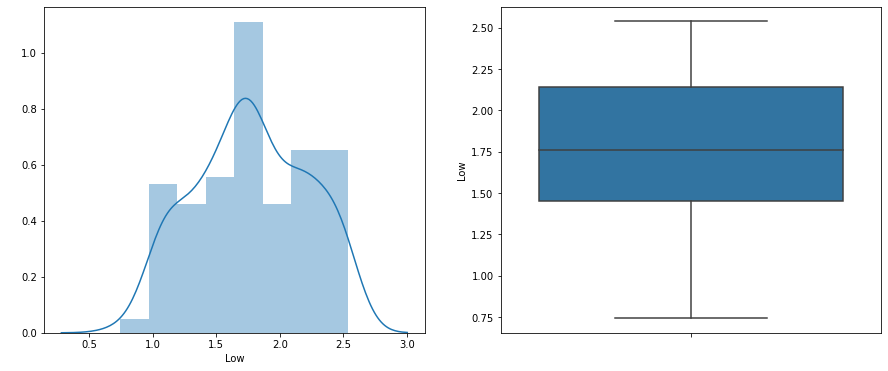

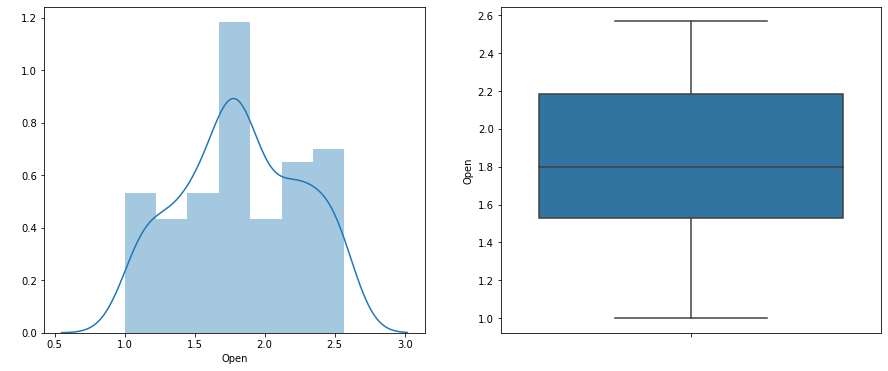

In [ ]:
#independent variables
for var in indep_var:
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    fig = sns.distplot(np.log10(df[var]))
    fig.set_ylabel(' ')
    fig.set_xlabel(var)

    plt.subplot(1, 2, 2)
    fig = sns.boxplot(y=np.log10(df[var]))
    fig.set_title('')
    fig.set_ylabel(var)

BIVARIATE ANALYSIS

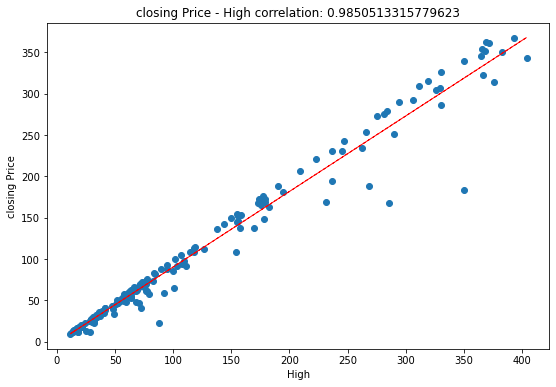

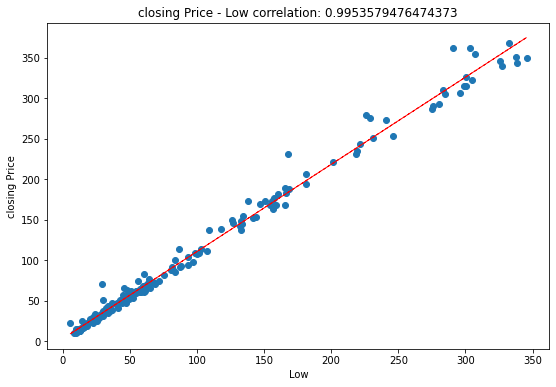

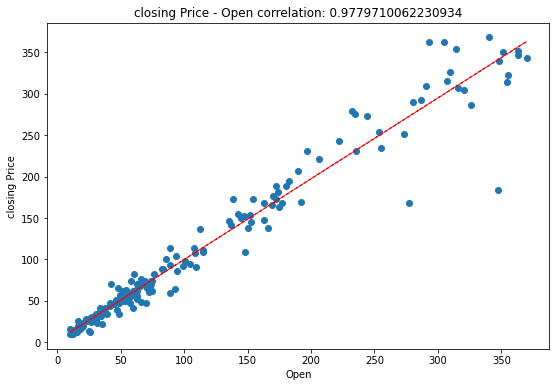

In [ ]:

#scatter plot between dependent variable with all independent variables.
for col in indep_var:
   fig = plt.figure(figsize=(9, 6))
   ax = fig.gca()
   feature = df[col]
   label = df['Close']
   correlation = feature.corr(label)
   plt.scatter(x=feature, y=label)
   plt.xlabel(col)
   plt.ylabel('closing Price')
   ax.set_title('closing Price - ' + col + ' correlation: ' + str(correlation))
   z = np.polyfit(df[col], df['Close'], 1)
   y_hat = np.poly1d(z)(df[col])
 
   plt.plot(df[col], y_hat, "r--", lw=1)
 
plt.show()

CORRELATION

Now, we will see the correlation between all the features in our data set.

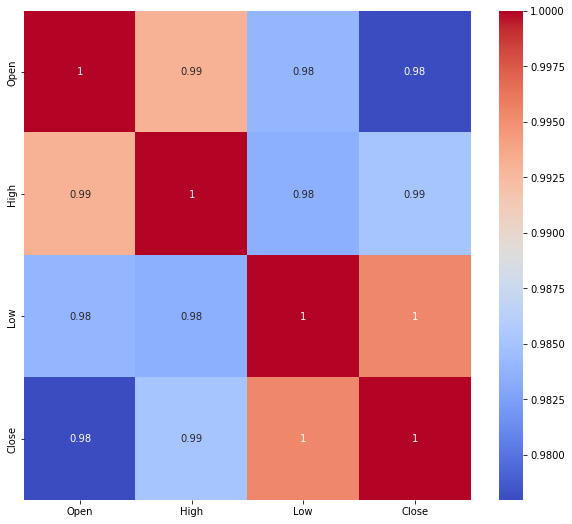

In [ ]:
#correlation plot
plt.figure(figsize=(10,9))
sns.heatmap(df.corr(), annot = True, cmap='coolwarm')
plt.show()


**MULTICOLLINEARITY**

In [ ]:
#Multicollinearity
#VIF score

def calc_vif(X):
 
   # Calculating VIF
   vif = pd.DataFrame()
   vif["variables"] = X.columns
   vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
 
   return(vif)

In [ ]:

calc_vif(indep_var)

,variables,VIF
0,High,167.057523
1,Low,71.574137
2,Open,175.185704


DATAFRAME TO STORE EVALUATION METRICS

In [ ]:
#empty data frame creation for evaluation metrics for each regression model into this data frame to compare at the end.
i=0
prediction_metrics=pd.DataFrame()

# Linear regression

In [ ]:
dep_var = 'Close'

In [ ]:
# Create a list of independent variables
indep_var = list(set(df.columns.tolist()) - {dep_var})

In [ ]:
indep_var

['Low', 'High', 'Date', 'Open']

In [ ]:
# Create the data of independent variables
X = df[indep_var].values

# Create the dependent variable data
y = df[dep_var].values

In [ ]:
df[indep_var]

,Low,High,Date,Open
0,11.25,14.00,Jul-05,13.00
1,12.55,14.88,Aug-05,12.58
2,12.27,14.87,Sep-05,13.48
3,12.40,14.47,Oct-05,13.20
4,12.88,13.88,Nov-05,13.35
...,...,...,...,...
180,11.10,28.30,Jul-20,25.60
181,11.85,17.16,Aug-20,12.00
182,12.75,15.34,Sep-20,14.30
183,12.11,14.01,Oct-20,13.30


we drop the date column for a better prediction


In [ ]:
indep_var=df[['High','Low','Open']]
dep_var=df['Close']

In [ ]:
#train test data split
x_train, x_test,y_train, y_test = train_test_split(indep_var,dep_var,test_size=.20,random_state=1)

In [ ]:
x_train[0:5]

,High,Low,Open
59,59.90,52.60,56.7
73,63.96,50.51,62.9
120,175.58,156.45,169.0
145,368.52,337.37,363.0
118,176.96,157.80,170.0


In [ ]:
#data transformation
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [ ]:
# Fitting Multiple Linear Regression to the Training set
regressor = LinearRegression()
regressor.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
regressor.intercept_

7.981643192931017

In [ ]:
regressor.coef_

array([ 206.39223501,  339.75965241, -178.58396386])

In [ ]:
y_pred_train = regressor.predict(x_train)

In [ ]:
y_train

59      53.83
73      55.61
120    165.74
145    351.15
118    176.52
        ...  
133    272.56
137    231.26
72      62.13
140    309.82
37      26.83
Name: Close, Length: 148, dtype: float64

In [ ]:
# Predicting the Test set results
y_pred = regressor.predict(x_test)

In [ ]:
#Predicted closing day on the test data
y_pred

array([ 26.5264613 ,  30.04697913,  52.99506974,  14.74919015,
       147.01000347, 339.97588471,  47.57404618,  26.7156191 ,
        25.53891247,  51.5485512 , 167.1168406 ,  52.40492841,
        15.03278394, 317.19036116,  74.02532594,  48.98214465,
        28.10792019, 134.70037858, 106.16190122,  90.75305749,
        28.99576342,  15.52145954, 108.22518038,  58.74416284,
       165.96721099,  19.27101903,  15.01972066,  51.82026038,
        30.42231711,  62.47316615, 261.58897929, 338.47373229,
        65.29568021, 232.0096057 ,  95.84913545,  54.02351579,
       242.48451636])

In [ ]:
# Actual closing day   on test data
y_test

16      25.32
179     25.60
66      52.59
40      12.26
166    147.95
155    339.60
97      48.65
177     27.95
35      22.85
54      49.84
116    163.31
56      50.97
4       13.41
149    315.05
81      70.07
31      49.42
47      29.68
126    149.38
106    113.89
105     88.14
48      31.93
11      15.62
108    108.21
78      65.99
117    167.96
14      18.46
42      12.24
29      49.81
19      28.63
82      66.02
164    275.05
154    346.20
102     61.59
136    234.28
93     100.28
53      53.41
132    243.44
Name: Close, dtype: float64

In [ ]:
# Tabular comparision of Actual and Predicted closing price in the test dataset

diff_df = pd.DataFrame({'Actual_Price': y_test, 'Predicted_Price': y_pred})

In [ ]:
diff_df

,Actual_Price,Predicted_Price
16,25.32,26.526461
179,25.60,30.046979
66,52.59,52.995070
40,12.26,14.749190
166,147.95,147.010003
155,339.60,339.975885
97,48.65,47.574046
177,27.95,26.715619
35,22.85,25.538912
54,49.84,51.548551


In [ ]:
#defining mape
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [ ]:
#evaluation metrics
MAE = mean_absolute_error((y_test), (y_pred))
print("MAE :" ,MAE)

MSE  = mean_squared_error((y_test), (y_pred))
print("MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("RMSE :" ,RMSE)

MAPE=mape(y_test, y_pred)
print("MAPE :" ,MAPE)

MAE : 3.052764712964646
MSE : 19.988578593595022
RMSE : 4.470858820584142
MAPE : 5.404201340281821


In [ ]:
#Inserting errors in dataframe
prediction_metrics.loc[i,"Model_Name"]='Linear regression'
prediction_metrics.loc[i,"MAE"]=round(MAE,2)
prediction_metrics.loc[i,"MSE"]=round(MSE,2)
prediction_metrics.loc[i,"RMSE"]=round(RMSE,2)
prediction_metrics.loc[i,"MAPE"]=round(MAPE,2)

i+=1

In [ ]:
r2_score(y_train, y_pred_train)

0.9943947124704909

In [ ]:
r2_score(y_test, y_pred)

0.9978412541225983

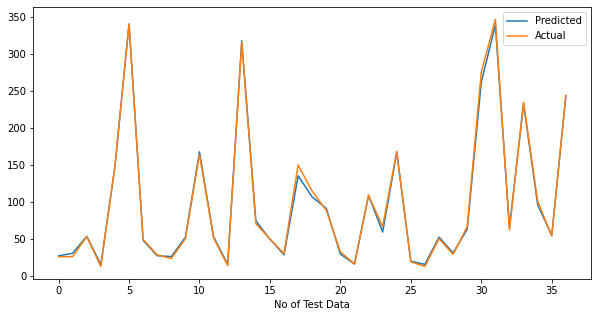

In [ ]:
#actual-predicted values plot
plt.figure(figsize=(10,5))
plt.plot(y_pred)
plt.plot(np.array(y_test))
plt.legend(["Predicted","Actual"])
plt.xlabel('No of Test Data')
plt.show()

# Implementing Lasso regression

In [ ]:
from sklearn.linear_model import Lasso
lasso  = Lasso(alpha=0.1 , max_iter= 3000)

lasso.fit(x_train, y_train)

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=3000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [ ]:
lasso.score(x_train, y_train)

0.9910691223999812

In [ ]:
# Cross validation
from sklearn.model_selection import GridSearchCV
lasso = Lasso()
parameters = {'alpha': [1e-15,1e-13,1e-10,1e-8,1e-5,1e-4,1e-3,1e-2,1e-1,1,5,10,20,30,40,45,50,55,60,100,0.0014]}
lasso_regressor = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv=5)
lasso_regressor.fit(x_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [1e-15, 1e-13, 1e-10, 1e-08, 1e-05, 0.0001,
                                   0.001, 0.01, 0.1, 1, 5, 10, 20, 30, 40, 45,
                                   50, 55, 60, 100, 0.0014]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [ ]:
print("The best fit alpha value is found out to be :" ,lasso_regressor.best_params_)
print("\nUsing ",lasso_regressor.best_params_, " the negative mean squared error is: ", lasso_regressor.best_score_)

The best fit alpha value is found out to be : {'alpha': 0.01}

Using  {'alpha': 0.01}  the negative mean squared error is:  -62.90049172560616


In [ ]:
#prediction
y_pred = lasso_regressor.predict(x_test)

In [ ]:
#evaluation metrics

MAE=mean_absolute_error((y_test), (y_pred))
print("MAE :" ,MAE)

MSE  = mean_squared_error((y_test), (y_pred))
print("MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("RMSE :" ,RMSE)

MAPE=mape(y_test, y_pred)
print("MAPE :" ,MAPE)

MAE : 3.130856893860506
MSE : 20.878651216190214
RMSE : 4.569316274475889
MAPE : 5.53404458516646


In [ ]:
r2_score(y_train, y_pred_train)

0.9943947124704909

In [ ]:
r2_score(y_test, y_pred)

0.9977451271971334

In [ ]:
#Inserting errors in dataframe
prediction_metrics.loc[i,"Model_Name"]='Lasso regression'
prediction_metrics.loc[i,"MAE"]=round(MAE,2)
prediction_metrics.loc[i,"MSE"]=round(MSE,2)
prediction_metrics.loc[i,"RMSE"]=round(RMSE,2)
prediction_metrics.loc[i,"MAPE"]=round(MAPE,2)


i=i+1

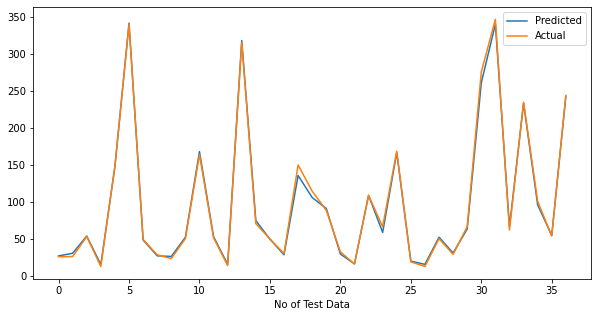

In [ ]:
#actual-predicted values plot
plt.figure(figsize=(10,5))
plt.plot(y_pred)
plt.plot(np.array(y_test))
plt.legend(["Predicted","Actual"])
plt.xlabel('No of Test Data')
plt.show()